In [105]:
#Importing all the required libraries 
import pandas as pd 
import numpy as np
import math
import scipy as s
import seaborn as sea 

In [106]:
#Importing the Data with the delimiter
df1 = pd.read_csv('auto-mpg.data' , delimiter = '\s+' )

In [107]:
print(df1.shape) 

(400, 9)


In [108]:
duplicated = df1[df1.duplicated()] #Identifying the Duplicates 
print (duplicated) #Printing the Duplicated 
df1.drop_duplicates( keep='first' , inplace = True) #Command for removing the Duplicates from the Dataframe
print(df1.shape) # Dimension of the data frame after removing Duplicates 

      mpg  cylinders  displacement horsepower  weight  acceleration  \
96   16.0          6         225.0      105.0  3439.0          15.5   
158  13.0          8         351.0      158.0  4363.0          13.0   

     model_year  origin                   car_name  
96           71       1  plymouth satellite custom  
158          73       1                   ford ltd  
(398, 9)


In [109]:

print(pd.isnull(df1['horsepower']).any()) #For checking if there are any null values in the dataset for column horsepower 

False


In [110]:
df2 = df1[pd.to_numeric(arg = df1['horsepower'] , errors = 'coerce').notnull()] #Command to drop the Columns with non-integral values
 #This command basically will remove  the ? present in the Horsepower column 
print(df2.shape)

(392, 9)


In [111]:
#Splitting the Dataset in Traning and test data by keeping the 10% as the test and remaining 90 % as training 
from sklearn.model_selection import train_test_split
X= df2.iloc[:,:-1]
y= df2.iloc[: , -1]
X_train, X_test, y_train, y_test = train_test_split(X,  y, random_state = 0 , train_size = 0.9)

In [112]:
X_test1 = X_test.copy(deep =True) #Making this new dataframe so that I can have the orignal values of the X_test
# (Deep is turned as true so that no values of the copied datasframe are reflected on the new copied data frome)

In [113]:
#For assigning null values to the horspower column of X_test
X_test1['horsepower'] = pd.NA

In [114]:
X_train['horsepower'].dtype

dtype('O')

In [115]:
#Calculating the mean and the median of the Horsepower dataset from X_train
X_train['horsepower'] = X_train['horsepower'].astype('float') # This is done in order to convert the dtype of the horsepower column
# from object type to the float type 
mean_horsepower = X_train['horsepower'].mean()
median_horsepower = X_train['horsepower'].median()
print(' Mean = ',mean_horsepower, '\n Median = ' , median_horsepower)

 Mean =  104.29545454545455 
 Median =  95.0


In [116]:
X_test1['horsepower'] = mean_horsepower #Filling in the missing values of the horspower with the mean value 
#Calculating the RMSE when the mean of X_train is replace
from sklearn.metrics import mean_squared_error
RMS_mean = mean_squared_error(X_test['horsepower'] , X_test1['horsepower'])
RMSE_mean =math.sqrt(RMS_mean)
print ('Mean RMSE -' , RMSE_mean )

Mean RMSE - 38.07237154691853


In [117]:
#Calculating the RMSE when the median of X_train is replaced for the horsepower value 
X_test1['horsepower'] = median_horsepower #Replacing  the missing values of the horspower with the median value 
RMS_median = mean_squared_error(X_test['horsepower'] , X_test1['horsepower'])
RMSE_median =math.sqrt(RMS_median)
print ('Median RMSE -' , RMSE_median)


Median RMSE - 39.59292866156784


In [118]:
#Here we are standardizing the data for the X_test in order to make it suitablel for the KNN Imputation method 
X_test_S = X_test1.copy(deep = True) 
X_test_S = X_test_S.drop(['cylinders' , 'model_year' , 'origin'], axis = 1 )
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
stan_data = sc.fit_transform(X_test_S)
X_test_S = pd.DataFrame(stan_data, columns = X_test_S.columns)

In [119]:
#Here we are standardizing the test set data in order for the KNN Imputation be trained on the standardized training data set 
X_train1 = X_train.copy(deep = True)
X_train1 = X_train1.drop([ 'cylinders' , 'model_year' , 'origin'] ,axis = 1)
sc1 = StandardScaler()
stan_data1 = sc1.fit_transform(X_train1)
X_train1_S = pd.DataFrame(stan_data1, columns = X_train1.columns)

In [120]:
X_test_S['horsepower'] = np.NaN

In [121]:
# For calculating the missing values of horsepower using KNN Imputer 
RMSE_DICT = {}

for i in range (1,6,2 ):

    sc1 = StandardScaler()
    stan_data1 = sc1.fit_transform(X_train1)
    X_train1_S = pd.DataFrame(stan_data1, columns = X_train1.columns)
    
    X_test_S['horsepower'] = np.NaN
    
    from sklearn.impute import KNNImputer
    imp = KNNImputer(missing_values= np.nan , n_neighbors=i)
    imp.fit(X_train1_S) #Fitting the KNN Imputation model for the training data set 
    X_test_trf = imp.transform(X_test_S) #Transforming the values of the test data set
    X_test1_trf = pd.DataFrame(X_test_trf, columns = X_test_S.columns) #Transforming the array into the proper column format that is 
# that is returned from the KNN Imputation method
    
#Here we are again inverse stadardizing the data in order for it to be compared with the earlier mean and median substititued 
# RMSE Values
    X_test1_trf_inv = sc1.inverse_transform(X_test1_trf)
    X_test1_trf_inv = pd.DataFrame(X_test1_trf_inv, columns = X_test1_trf.columns)
    
#Computing the RMSE for the inverse transformed KNN Imputed values and the orginal values    
    RMSK = mean_squared_error(X_test['horsepower'] , X_test1_trf_inv['horsepower'])
    RMSEK =math.sqrt(RMSK)
    RMSE_DICT[i] = RMSEK
#Printing the dictionary contatining all the 3 values of RMSE's for different values of k 
print(RMSE_DICT)

{1: 14.832396974191326, 3: 11.184562773950729, 5: 11.175508936956742}


In [122]:
#Finally filling in the values with the lowest RMSE Value which is neighbour = 5

sc = StandardScaler()
stan_data = sc.fit_transform(X_test_S)
X_test_S = pd.DataFrame(stan_data, columns = X_test_S.columns)
X_test_S['horsepower'] = np.NaN

imp = KNNImputer(missing_values= np.nan , n_neighbors=5)
imp.fit(X_train1_S) #Fitting the KNN Imputation model for the training data set 
X_test_trf = imp.transform(X_test_S) #Transforming the values of the test data set
X_test1_trf = pd.DataFrame(X_test_trf, columns = X_test_S.columns) #Transforming the array into the proper column format that is 
# that is returned from the KNN Imputation method

#Here we are again inverse stadardizing the data in order for it to be compared with the earlier mean and median substititued 
# RMSE Values
X_test1_trf_inv = sc1.inverse_transform(X_test1_trf)
X_test1_trf_inv = pd.DataFrame(X_test1_trf_inv, columns = X_test1_trf.columns)

c:\Users\Puru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Puru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Puru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [123]:
#For visualizing the final filled in values of the Horsepower Column
print(X_test1_trf_inv['horsepower'])

0      80.0
1      90.6
2     170.6
3      74.6
4      72.2
5      94.6
6      65.2
7      78.8
8      91.6
9      76.4
10     60.4
11    154.4
12     91.2
13    170.0
14    143.2
15     74.0
16     97.6
17    136.4
18     87.6
19     85.6
20    145.8
21    104.6
22     78.8
23     93.2
24     72.4
25    157.0
26     91.2
27     86.2
28     93.0
29    144.0
30    100.2
31     79.2
32     85.8
33     77.6
34    101.4
35     87.0
36     58.8
37    179.0
38    147.0
39    211.6
Name: horsepower, dtype: float64


In [124]:
#calculating the skewness for the mpg column also the value differs a bit from the excel as a few rows are already dropped
from scipy.stats import skew
skew(df2['mpg'])

0.45534138282810366

In [125]:
#Calculating kurtosis for the dataset
from scipy.stats import kurtosis
kurtosis(df2['mpg'])

-0.52470258338766

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\1759065907.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(df2['mpg'], kde = False)


<AxesSubplot: xlabel='mpg'>

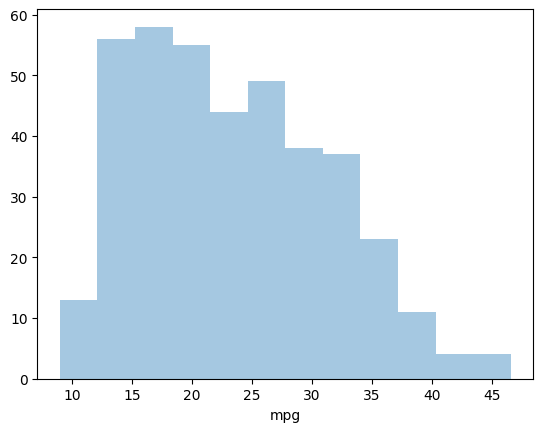

In [126]:
#Drawing the histogram for the displot function 
sea.distplot(df2['mpg'], kde = False)

In [127]:
#Finding the Outliers of the mpg using the IQR Approach

Q1 = np.percentile(df2['mpg'] ,25 )
Q3 = np.percentile (df2['mpg'], 75)
IQR = Q3 - Q1
print ('Q1', Q1, 'Q3',  Q3 ,'IQR',  IQR)
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 *IQR
print ('upper_limit', upper_limit ,'lower_limit',  lower_limit)


Q1 17.0 Q3 29.0 IQR 12.0
upper_limit 47.0 lower_limit -1.0


In [128]:
#For finding out the outlier in the function along with its index and then imputing it with the minimum or the maximum value
outliers = {}
for i in range (0 , len(df2['mpg'])):
    if df2['mpg'].iloc[i]>upper_limit:
        outliers[i] = df2['mpg'].iloc[i]
        df2['mpg'].iloc[i] = upper_limit
    elif df2['mpg'].iloc[i]<lower_limit:
        outliers[i] = df2['mpg'].iloc[i]
        df2['mpg'].iloc[i] = lower_limit
print(outliers)

{}


In [129]:
df2_c = df2.copy(deep = True) #Making the copy of the earlier data frame in order to preserve the 
#Values for the earlier dataframe 

In [130]:
df2_c['mpg'] = np.log((df2_c['mpg'])+1) # Making the mpg column follow the normal distribution  loge (x+1)

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3311967683.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(df2_c['mpg'])


<AxesSubplot: xlabel='mpg', ylabel='Density'>

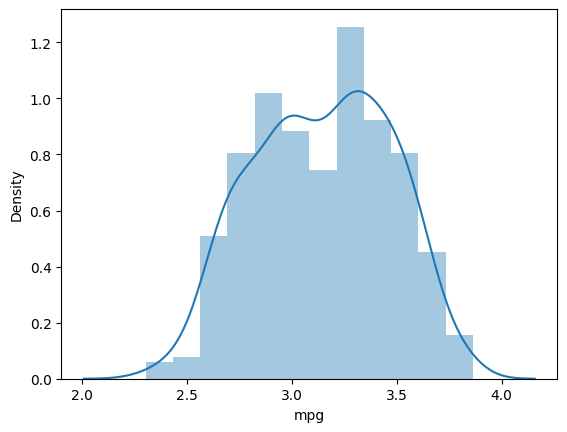

In [131]:
sea.distplot(df2_c['mpg'])

In [132]:
#Calculating the earlier and the new kurtosis and the skewness values and comparing them with 
# the older ones in order to see the difference 
print ('Earlier Kurtosis', kurtosis(df2['mpg']) , '   Earlier Skewness', skew(df2['mpg']))
print ('New Kurtosis    '  ,  kurtosis(df2_c['mpg']) , '   New Skewness  ' ,skew(df2_c['mpg']))

Earlier Kurtosis -0.52470258338766    Earlier Skewness 0.45534138282810366
New Kurtosis     -0.838612921315721    New Skewness   -0.10386599601768146


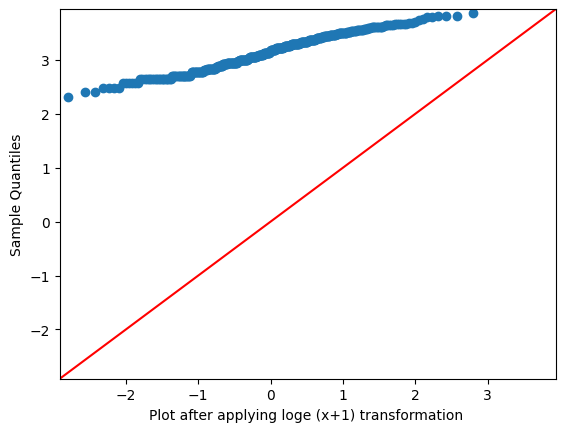

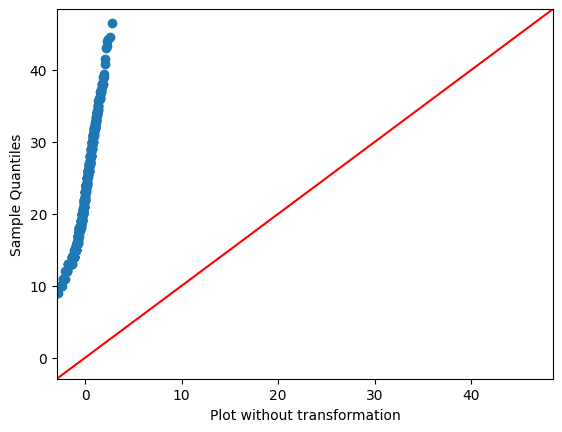

In [133]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot for the earlier and the new mpg value and seeing that it follows more normal distribution as compared to the
# previous non-transformed value 
fig = sm.qqplot(df2_c['mpg'], line='45' , xlabel = 'Plot after applying loge (x+1) transformation ')
fig = sm.qqplot(df2['mpg'], line='45' , xlabel = 'Plot without transformation')
plt.show()

In [134]:
#detect and correct outliers in the weight, displacement, horsepower and acceleration Columns

#Finding the Outliers of the mpg using the IQR Approach

Q1_weight = np.percentile(df2['weight'] ,25 )
Q3_weight = np.percentile (df2['weight'], 75)
IQR_weight = Q3_weight - Q1_weight
print (Q1_weight, Q3_weight , IQR_weight)
upper_limit_weight = Q3_weight + 1.5 * IQR_weight
lower_limit_weight = Q1_weight - 1.5 *IQR_weight
print (upper_limit_weight , lower_limit_weight)

outliers_weight = {}
for i in range (0 , len(df2['weight'])):
    if df2['weight'].iloc[i]>upper_limit_weight:
        outliers_weight[i] = df2['weight'].iloc[i]
        df2['weight'].iloc[i] = upper_limit_weight
    elif df2['weight'].iloc[i]<lower_limit_weight:
        outliers_weight[i] = df2['weight'].iloc[i]
        df2['weight'].iloc[i] = lower_limit_weight
print(outliers_weight)

2225.25 3614.75 1389.5
5699.0 141.0
{}


In [135]:
Q1_displacement = np.percentile(df2['displacement'] ,25 )
Q3_displacement = np.percentile (df2['displacement'], 75)
IQR_displacement = Q3_displacement - Q1_displacement
print (Q1_displacement, Q3_displacement , IQR_displacement)
upper_limit_displacement = Q3_displacement + 1.5 * IQR_displacement
lower_limit_displacement = Q1_displacement - 1.5 *IQR_displacement
print (upper_limit_displacement , lower_limit_displacement)

outliers_displacement = {}
for i in range (0 , len(df2['displacement'])):
    if df2['displacement'].iloc[i]>upper_limit_displacement:
        outliers_displacement[i] = df2['displacement'].iloc[i]
        df2['displacement'].iloc[i] = upper_limit_displacement
    elif df2['displacement'].iloc[i]<lower_limit_displacement:
        outliers_displacement[i] = df2['displacement'].iloc[i]
        df2['displacement'].iloc[i] = lower_limit_displacement
print(outliers_displacement)

105.0 275.75 170.75
531.875 -151.125
{}


In [136]:
Q1_acceleration = np.percentile(df2['acceleration'] ,25 )
Q3_acceleration = np.percentile (df2['acceleration'], 75)
IQR_acceleration = Q3_acceleration - Q1_acceleration
print (Q1_acceleration, Q3_acceleration , IQR_acceleration)
upper_limit_acceleration = Q3_acceleration + 1.5 * IQR_acceleration
lower_limit_acceleration = Q1_acceleration - 1.5 *IQR_acceleration
print (upper_limit_acceleration , lower_limit_acceleration)

outliers_acceleration = {}
for i in range (0 , len(df2['acceleration'])):
    if df2['acceleration'].iloc[i]>upper_limit_acceleration:
        outliers_acceleration[i] = df2['acceleration'].iloc[i]
        df2['acceleration'].iloc[i] = upper_limit_acceleration
    elif df2['acceleration'].iloc[i]<lower_limit_acceleration:
        outliers_acceleration[i] = df2['acceleration'].iloc[i]
        df2['acceleration'].iloc[i] = lower_limit_acceleration
print(outliers_acceleration)

13.775 17.025 3.2499999999999982
21.899999999999995 8.900000000000002
{7: 8.5, 9: 8.5, 11: 8.0, 58: 23.5, 193: 22.2, 194: 22.1, 207: 21.9, 297: 24.8, 298: 22.2, 324: 23.7, 388: 24.6}


C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2123868593.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['acceleration'].iloc[i] = lower_limit_acceleration
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2123868593.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['acceleration'].iloc[i] = upper_limit_acceleration


In [137]:

df2['horsepower'] = df2['horsepower'].astype('float')
Q1_horsepower = np.percentile(df2['horsepower'] ,25 )
Q3_horsepower = np.percentile (df2['horsepower'], 75)
IQR_horsepower = Q3_horsepower - Q1_horsepower
print (Q1_horsepower, Q3_horsepower , IQR_horsepower)
upper_limit_horsepower = Q3_horsepower + 1.5 * IQR_horsepower
lower_limit_horsepower = Q1_horsepower - 1.5 *IQR_horsepower
print (upper_limit_horsepower , lower_limit_horsepower)

outliers_horsepower = {}
for i in range (0 , len(df2['horsepower'])):
    if df2['horsepower'].iloc[i]>upper_limit_horsepower:
        outliers_horsepower[i] = df2['horsepower'].iloc[i]
        df2['horsepower'].iloc[i] = upper_limit_horsepower
    elif df2['horsepower'].iloc[i]<lower_limit_horsepower:
        outliers_horsepower[i] = df2['horsepower'].iloc[i]
        df2['horsepower'].iloc[i] = lower_limit_horsepower
print(outliers_horsepower)

75.0 126.0 51.0
202.5 -1.5
{6: 220.0, 7: 215.0, 8: 225.0, 13: 225.0, 25: 215.0, 27: 210.0, 66: 208.0, 93: 215.0, 94: 225.0, 115: 230.0}


C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3053681913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['horsepower'] = df2['horsepower'].astype('float')
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3053681913.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['horsepower'].iloc[i] = upper_limit_horsepower


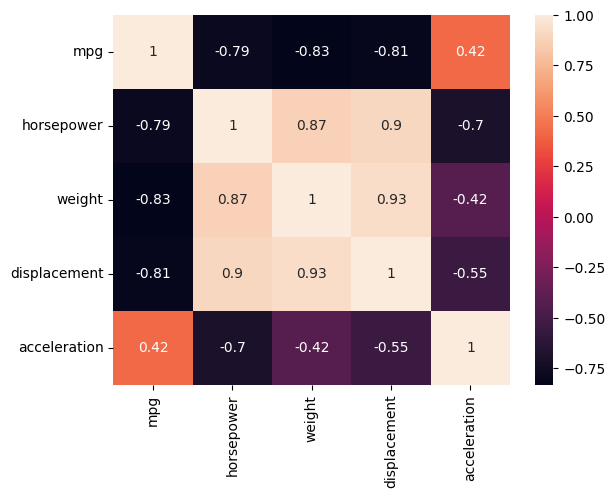

In [138]:
#Drawing the sns correlation matrix for the dataset for mpg, horsepower, weight, displacement, and acceleration variables 
Correlation_Matrix = df2[['mpg', 'horsepower', 'weight', 'displacement', 'acceleration']].corr()
sea.heatmap(Correlation_Matrix , annot= True)
plt.show()

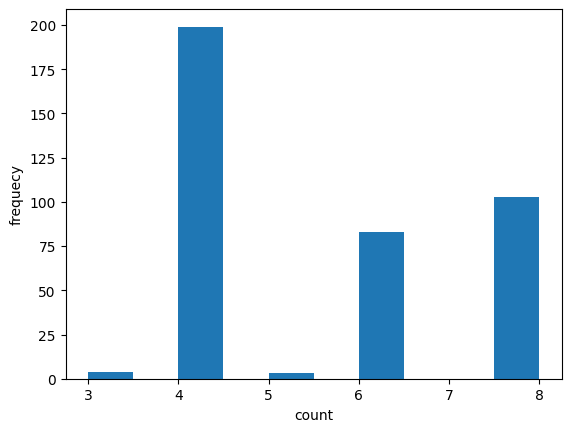

Cylin.  Count
4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64


In [139]:
#Checking the Outliers by identifying the biggest categories by plotting the histogram  
ax = df2['cylinders'].plot.hist()
ax.set_ylabel("frequecy")
ax.set_xlabel("count")
plt.show()
print('Cylin.  Count')
print(df2['cylinders'].value_counts())


In [140]:
#Creating a copy of the data frame as we need to have the previous values to compare is the 3 value assign to 4 and 5 to 6 
df3 = df2.copy(deep =True)

In [141]:
#Printing the indexes for the outliers so that we can verify is the 3 value assign to 4 and 5 to 6 
indexes = {}
for i in range(0,len(df3['cylinders'])):
    if df3['cylinders'].iloc[i] == 3 or df3['cylinders'].iloc[i] == 5:
        indexes[i] = df3['cylinders'].iloc[i]
        df3['cylinders'].iloc[i] = np.NaN

        
print(indexes)

{70: 3, 110: 3.0, 241: 3.0, 272: 5.0, 295: 5.0, 325: 5.0, 331: 3.0}


C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\96648631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['cylinders'].iloc[i] = np.NaN


In [142]:
#Dropping the excess columns as we only need to perform the KNN Imputation on the speciffic data frames 
df3 = df3.drop(['model_year', 'origin', 'car_name'], axis = 1)
df3['cylinders'] =  df3['cylinders'].astype('category')

In [143]:
#Scaling the data as it is good to scale the data prior to performing the KNN Imputation step
sc3 = StandardScaler()
stan_data2 = sc3.fit_transform(df3)
df4 = pd.DataFrame(stan_data2, columns = df3.columns)

In [144]:
# Assigining the nan value after the scaling of the dataset
keys = list(indexes.keys())
for i in range(0,len(keys)):
    df4['cylinders'].iloc[keys[i]] = np.NaN

In [145]:
#Performing the KNN Imputation on the Standardized dataset we will need to keep the neigbors as 1 otherwise it will start giving up
# some meaningless average for the required categorical data prediction
imp1 = KNNImputer(missing_values= np.nan , n_neighbors=1)
imp1_fit = imp1.fit_transform(df4)
df5 = pd.DataFrame(imp1_fit, columns = df3.columns)

In [146]:
#Inverse transforming the dataset in order to check the columns as categorical values 
df5 = sc3.inverse_transform(df5)
df5 = pd.DataFrame(df5, columns = df4.columns)

In [147]:
#Converting the data type of the column to be as the category
df5['cylinders'] =  df5['cylinders'].astype('category')
df5['cylinders'].dtype

CategoricalDtype(categories=[4.0, 6.0, 8.0], ordered=False)

In [148]:
#Comparing the previous and the new class of the dataset after the removal of the outliers using the KNN Imputation method 
keys = list(indexes.keys())
for i in range(0,len(keys)):
    print(indexes[keys[i]] , '  ',  df5['cylinders'].iloc[keys[i]])

3    4.0
3.0    4.0
3.0    4.0
5.0    4.0
5.0    4.0
5.0    6.0
3.0    4.0


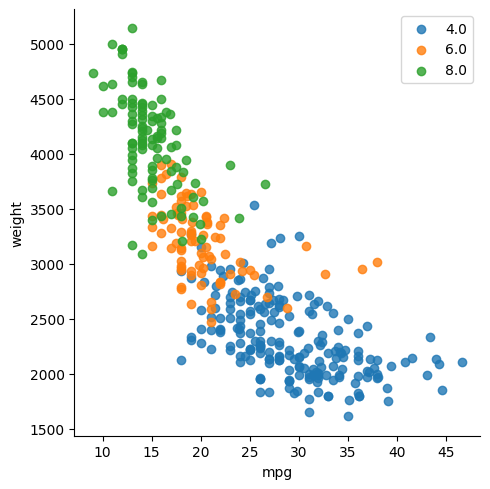

In [149]:
#Plotting the scatter plot for Weight vs MPG Column in the presence of the number of cylinders 
sea.lmplot( x="mpg", y="weight", data=df5, fit_reg=False, hue='cylinders', legend=False)
plt.legend(loc='upper right')
plt.show()

In [150]:
print(len(df2) , len(df5))

392 392


In [151]:
#Assigning the newly transformed outlier removed value of the cylinder data column to the earlier complete dataset 
for i in range(0, len(df2['cylinders'])):
    for j in range(0, len(df5['cylinders'])):
        if i ==j:
            df2['cylinders'].iloc[i] = df5['cylinders'].iloc[j]
            
            
        

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2188101148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cylinders'].iloc[i] = df5['cylinders'].iloc[j]


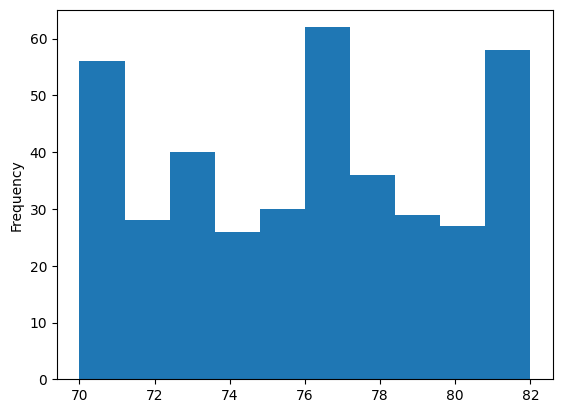

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: model_year, dtype: int64


In [152]:
df2['model_year'].plot.hist()
plt.show()
print(df2['model_year'].value_counts())

In [153]:
#Converting the model_year to and indexed datetime format 
df2['model_year'] = pd.to_datetime(df2['model_year'], format = '%y')

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\329256244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['model_year'] = pd.to_datetime(df2['model_year'], format = '%y')


In [154]:
print(df2['model_year'])
print(df2['model_year'].value_counts())

0     1970-01-01
1     1970-01-01
2     1970-01-01
3     1970-01-01
4     1970-01-01
         ...    
395   1982-01-01
396   1982-01-01
397   1982-01-01
398   1982-01-01
399   1982-01-01
Name: model_year, Length: 392, dtype: datetime64[ns]
1973-01-01    40
1978-01-01    36
1976-01-01    34
1975-01-01    30
1982-01-01    30
1970-01-01    29
1979-01-01    29
1972-01-01    28
1977-01-01    28
1981-01-01    28
1971-01-01    27
1980-01-01    27
1974-01-01    26
Name: model_year, dtype: int64


<AxesSubplot: >

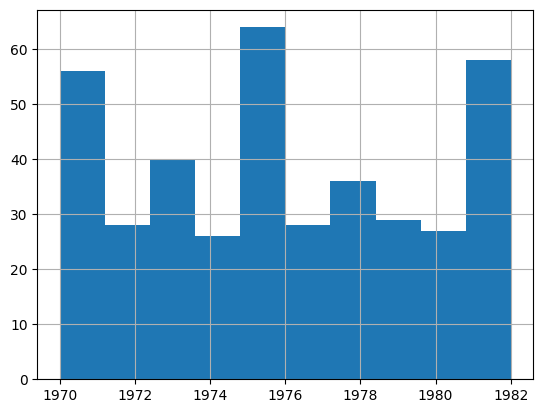

In [155]:
df2['model_year'].hist()

In [156]:
df2['year_class'] = pd.NA

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2397951838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_class'] = pd.NA


In [157]:
df2['model_year'].value_counts()

1973-01-01    40
1978-01-01    36
1976-01-01    34
1975-01-01    30
1982-01-01    30
1970-01-01    29
1979-01-01    29
1972-01-01    28
1977-01-01    28
1981-01-01    28
1971-01-01    27
1980-01-01    27
1974-01-01    26
Name: model_year, dtype: int64

In [158]:
#Assiging the different classes based on the the interval we have divided them into  we can 
#also call in the .resample function for the same but as in this dataset the data is in date 
#sorted format hence this would also work based on indexes 
df2['year_class'].iloc[:124] = 'Class A'
df2['year_class'].iloc[124:242] = 'Class B'
df2['year_class'].iloc[242:] = 'Class C'


C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2913751010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_class'].iloc[:124] = 'Class A'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2913751010.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_class'].iloc[124:242] = 'Class B'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2913751010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_class'].ilo

In [159]:
print(df2['year_class'].value_counts())

Class C    150
Class A    124
Class B    118
Name: year_class, dtype: int64


In [160]:
#Switching the datatype of the column year_class to category
df2['year_class'] = df2['year_class'].astype('category')

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3565944171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_class'] = df2['year_class'].astype('category')


Text(0.5, 0.98, 'Boxplot for MPG')

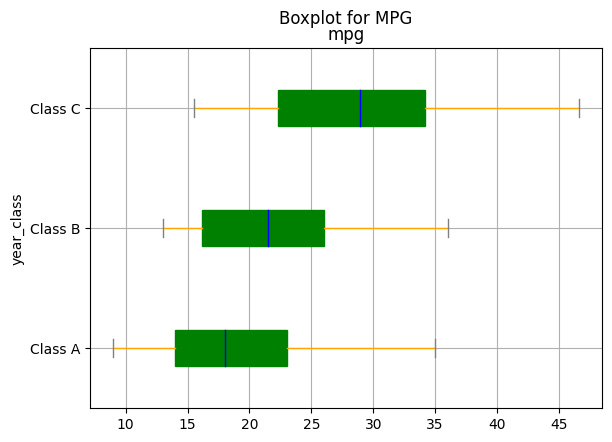

In [161]:
# Plotting the boxplot for viewing the change in MPG as the median has increased with each class suggesting that the mpg has 
# improved over the years.

props = dict(boxes="Green", whiskers="Orange", medians="Blue", caps="Gray")
bp = df2.boxplot(column = 'mpg', by='year_class' , vert = False , color=props, patch_artist=True )
plt.suptitle("Boxplot for MPG")

Text(0, 0.5, 'year_class')

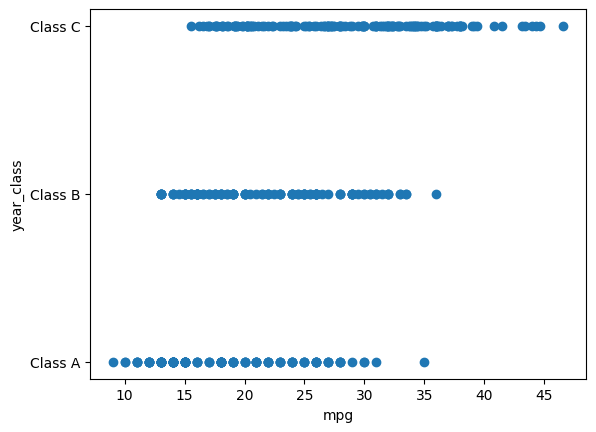

In [162]:
#analyse mpg improvements over the three time groups we have created.
plt.scatter(df2['mpg'] , df2['year_class'] )
plt.xlabel('mpg')
plt.ylabel('year_class')

In [163]:
#Assigining different regions based on the code 
for i in range(0, len(df2)):
    if df2['origin'].iloc[i] == 1 :
        df2['origin'].iloc[i] = 'Europe'
    elif df2['origin'].iloc[i] == 2 :
        df2['origin'].iloc[i] = 'USA'
    elif df2['origin'].iloc[i] == 3 :
        df2['origin'].iloc[i] = 'Japan'

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2380676102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['origin'].iloc[i] = 'Europe'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2380676102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['origin'].iloc[i] = 'Japan'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2380676102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['origin'].iloc[i] = 'USA'


In [164]:
#Chainging the datatype of the origin column as Catergorical 
df2['origin'] = df2['origin'].astype('category')
df2['origin'].dtype

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\1956420634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['origin'] = df2['origin'].astype('category')


CategoricalDtype(categories=['Europe', 'Japan', 'USA'], ordered=False)

Text(0.5, 0.98, 'Boxplot for MPG')

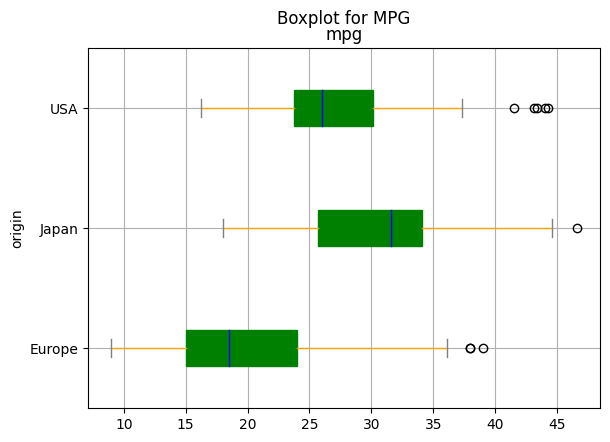

In [165]:
#Plotting the boxplots for the MPG based on origin  
props = dict(boxes="Green", whiskers="Orange", medians="Blue", caps="Gray")
bp = df2.boxplot(column = 'mpg', by='origin' , vert = False , color=props, patch_artist=True )
plt.suptitle("Boxplot for MPG")

In [166]:
#Forming a new column in the dataframe named brand and put the first string from the car_name columns into this column with the 
# help of Regular Expressions
df2['Brand'] = df2['car_name'].str.extract('^([\w\-]+)', expand=True) 

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\345374671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'] = df2['car_name'].str.extract('^([\w\-]+)', expand=True)


In [167]:
#For Analyzing the Car Brand names 
for i in range(0,len(df2)):
    print(df2['Brand'].iloc[i])

chevrolet
buick
plymouth
amc
ford
ford
chevrolet
plymouth
pontiac
amc
dodge
plymouth
chevrolet
buick
toyota
plymouth
amc
ford
datsun
volkswagen
peugeot
audi
saab
bmw
amc
ford
chevy
dodge
hi
datsun
chevrolet
toyota
amc
plymouth
chevrolet
ford
amc
chevrolet
pontiac
ford
plymouth
dodge
ford
pontiac
amc
chevrolet
pontiac
ford
mercury
opel
peugeot
fiat
toyota
datsun
volkswagen
plymouth
toyota
dodge
volkswagen
chevrolet
ford
chevrolet
pontiac
plymouth
ford
amc
mercury
buick
oldsmobile
chrysler
mazda
amc
chevrolet
ford
plymouth
volvo
volkswagen
peugeot
renault
ford
datsun
toyouta
dodge
toyota
buick
amc
chevrolet
ford
dodge
mercury
chevrolet
ford
plymouth
chrysler
buick
amc
plymouth
chevrolet
amc
ford
plymouth
volkswagen
chevrolet
ford
plymouth
oldsmobile
amc
toyota
chevrolet
datsun
maxda
ford
mercury
fiat
chevrolet
pontiac
fiat
opel
audi
volvo
dodge
saab
toyota
oldsmobile
plymouth
amc
chevrolet
datsun
ford
toyota
chevrolet
chevrolet
amc
plymouth
ford
buick
dodge
ford
amc
audi
volkswagen
opel


In [168]:
#Correcting the brand names for short forms and typos also counting each occurrence using the count keyword to record the number
# of times I have made overall correction in the entire dataframe
corrections = {}
count = 0 
for i in range(0,len(df2)):
    if df2['Brand'].iloc[i] == 'vw':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='volkswagen'
        count = count+1
    elif df2['Brand'].iloc[i] == 'chevy':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='chevrolet'
        count = count+1
    elif df2['Brand'].iloc[i] == 'maxda':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='mazda'
        count = count+1
    elif df2['Brand'].iloc[i] == 'toyouta':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='toyota'
        count = count+1
    elif df2['Brand'].iloc[i] == 'chevroelt':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='chevrolet'
        count = count+1        
    elif df2['Brand'].iloc[i] == 'vokswagen':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='volkswagen'
        count = count+1       
    elif df2['Brand'].iloc[i] == 'mercedes-benz':
        corrections[i] = df2['Brand'].iloc[i]
        df2['Brand'].iloc[i] ='mercedes'
        count = count+1  
        
print('Total number of corrections made are -', count) 
print ('The indexes and the prior notations are', corrections)

Total number of corrections made are - 16
The indexes and the prior notations are {26: 'chevy', 81: 'toyouta', 110: 'maxda', 159: 'chevroelt', 195: 'vw', 209: 'mercedes-benz', 211: 'chevy', 291: 'vw', 292: 'maxda', 307: 'vw', 323: 'vw', 324: 'vw', 326: 'mercedes-benz', 329: 'vokswagen', 388: 'vw', 391: 'chevy'}


C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\708190173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] ='chevrolet'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\708190173.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] ='toyota'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\708190173.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] ='mazda'
C:\Users\Pu

In [169]:
#Rechecking the  brand column division using the value_counts function
df2['Brand'].value_counts()

ford          48
chevrolet     47
plymouth      31
dodge         28
amc           27
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
honda         13
mazda         12
mercury       11
oldsmobile    10
fiat           8
peugeot        8
audi           7
volvo          6
chrysler       6
saab           4
opel           4
subaru         4
mercedes       3
renault        3
cadillac       2
bmw            2
capri          1
hi             1
triumph        1
nissan         1
Name: Brand, dtype: int64

In [170]:
# Assigning the value as Other to the Brands having count<=5 
for i in range(0,len(df2)):
    if df2['Brand'].value_counts()[df2['Brand'].iloc[i]]<6:
        df2['Brand'].iloc[i] = 'Other'
        count = count+1      

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3731949047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] = 'Other'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3731949047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] = 'Other'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\3731949047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Brand'].iloc[i] = 'Other'
C:\Users\Puru

In [171]:
#Printing the total number of corrections we have made till now for the brand Column
print('The total correction made till now are', count)  

The total correction made till now are 42


In [172]:
df2['Brand'].value_counts()

ford          48
chevrolet     47
plymouth      31
dodge         28
amc           27
Other         26
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
honda         13
mazda         12
mercury       11
oldsmobile    10
fiat           8
peugeot        8
audi           7
chrysler       6
volvo          6
Name: Brand, dtype: int64

In [173]:
#Changing the datatype of the origin and Cylinders  column to be as categorical 
df2['origin'] = df2['origin'].astype('category')
df2['cylinders'] = df2['cylinders'].astype('category')

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\1408206968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['origin'] = df2['origin'].astype('category')
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\1408206968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cylinders'] = df2['cylinders'].astype('category')


In [174]:
#generating the One Hot Encoded Columns using the get dummies function we can also use 
#One hot encoder from the Sklern.preprocessing library but this one is the much simpler approach
df_OneHotEncode = pd.get_dummies(df2.origin , sparse = False)
df_OneHotEncode1 = pd.get_dummies(df2.cylinders , sparse = False)


In [175]:
#Concatinating the Newly generated rows for the Origin and Cylinders column to the orignal
#Dataframe 
df6 = pd.concat([df2 , df_OneHotEncode ,df_OneHotEncode1 ] , axis =1  )
print(df6)

      mpg cylinders  displacement  horsepower  weight  acceleration  \
0    18.0         8         307.0       130.0  3504.0          12.0   
1    15.0         8         350.0       165.0  3693.0          11.5   
2    18.0         8         318.0       150.0  3436.0          11.0   
3    16.0         8         304.0       150.0  3433.0          12.0   
4    17.0         8         302.0       140.0  3449.0          10.5   
..    ...       ...           ...         ...     ...           ...   
395  27.0         4         140.0        86.0  2790.0          15.6   
396  44.0         4          97.0        52.0  2130.0          21.9   
397  32.0         4         135.0        84.0  2295.0          11.6   
398  28.0         4         120.0        79.0  2625.0          18.6   
399  31.0         4         119.0        82.0  2720.0          19.4   

    model_year  origin                   car_name year_class       Brand  \
0   1970-01-01  Europe  chevrolet chevelle malibu    Class A   chevrole

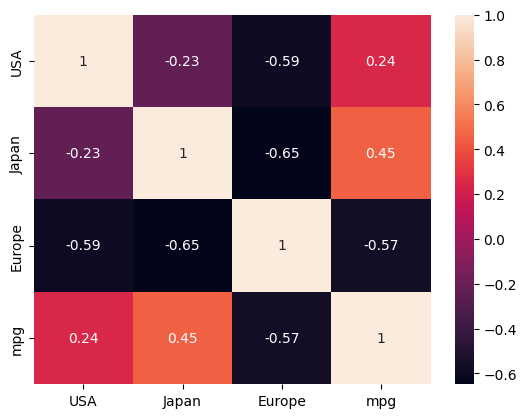

In [176]:
#Plotting the correlation matrix for the origin column with the mpg column 
Correlation_Matrix = df6[['USA', 'Japan' , 'Europe',  'mpg']].corr()
sea.heatmap(Correlation_Matrix , annot= True)
plt.show()

In [177]:
#Checking in the correlation coefficients using the pointbiserial function
import scipy.stats as stats
print(stats.pointbiserialr(df6['mpg'], df6['USA'] ) , 'USA vs mpg')
print( stats.pointbiserialr(df6['mpg'], df6['Japan'] ), 'Japan vs mpg')
print (stats.pointbiserialr(df6['mpg'], df6['Europe'] ), 'Europe vs mpg')

PointbiserialrResult(correlation=0.2443125009843881, pvalue=9.77654342305441e-07) USA vs mpg
PointbiserialrResult(correlation=0.4514536299297465, pvalue=4.420895151852598e-21) Japan vs mpg
PointbiserialrResult(correlation=-0.5651605934550841, pvalue=1.8397072868725599e-34) Europe vs mpg


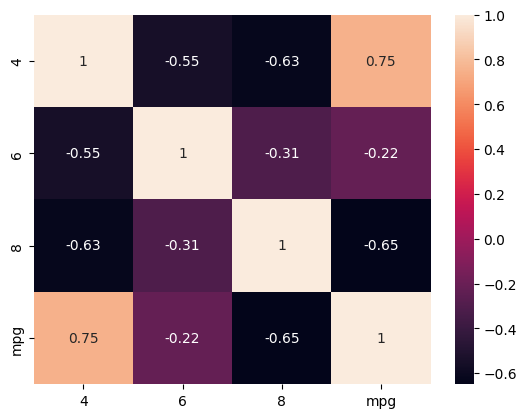

In [178]:
#Plotting the correlation matrix for the One hot encoded Cylinders  column with the mpg column 
Correlation_Matrix_1 = df6[[4, 6 , 8,  'mpg']].corr()
sea.heatmap(Correlation_Matrix_1 , annot= True)
plt.show()

In [179]:
#Checking in the correlation coefficients using the pointbiserial function
print(stats.pointbiserialr(df6[4], df6['mpg'] ) , '4 Cyl vs mpg')
print( stats.pointbiserialr(df6[6], df6['mpg'] ), '6 Cyl vs mpg')
print (stats.pointbiserialr(df6[8], df6['mpg'] ), '8 Cyl vs mpg')

PointbiserialrResult(correlation=0.7528329373331528, pvalue=7.783172982761409e-73) 4 Cyl vs mpg
PointbiserialrResult(correlation=-0.2195355855886975, pvalue=1.152807330965387e-05) 6 Cyl vs mpg
PointbiserialrResult(correlation=-0.6496670519179473, pvalue=2.280367635736409e-48) 8 Cyl vs mpg


Text(0.5, 0.98, 'Boxplot for MPG')

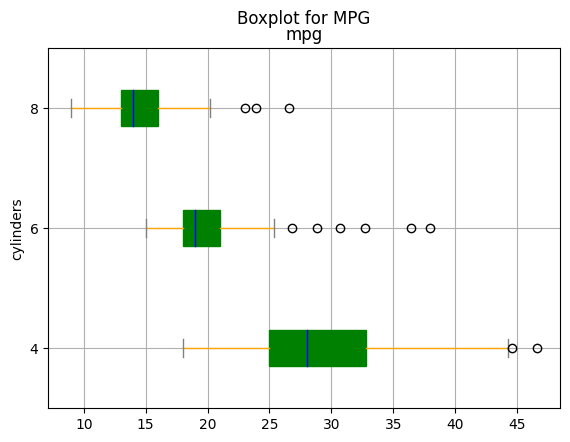

In [180]:
#Plotting the boxplots for the MPG based on Cylinders to verify the relationship b/w the correlations coefficient
#of the mpg vs One hot encoded cylinders column 
props = dict(boxes="Green", whiskers="Orange", medians="Blue", caps="Gray")
bp = df2.boxplot(column = 'mpg', by='cylinders' , vert = False , color=props, patch_artist=True  )
plt.suptitle("Boxplot for MPG") 

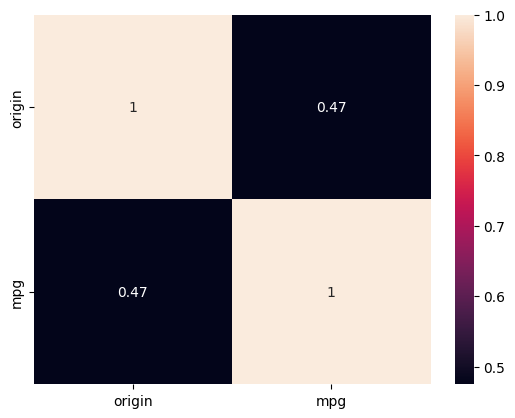

In [181]:
#label Encoding the Origin Column
from sklearn.preprocessing import LabelEncoder
LE1 = LabelEncoder()
df6['origin'] = LE1.fit_transform(df6['origin']) 
Correlation_Matrix_2 = df6[['origin' , 'mpg' ]].corr()
sea.heatmap(Correlation_Matrix_2 , annot= True)
plt.show()

In [182]:
#Verifying the label Encoded Values 
df6['origin'].value_counts()


0    245
1     79
2     68
Name: origin, dtype: int64

In [183]:
#Checking in the correlation coefficients using the pointbiserial function
print(stats.pointbiserialr(df6['origin'], df6['mpg'] ) , 'Origin vs mpg')

PointbiserialrResult(correlation=0.4748002968835666, pvalue=1.959478880275074e-23) Origin vs mpg


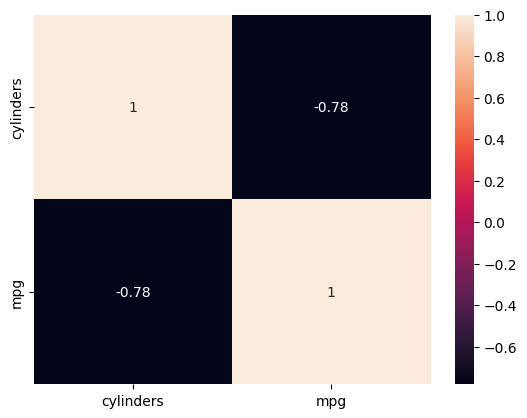

In [184]:
#Label encoding the Cylinder column and plotting the correlation matrix 
LE2 = LabelEncoder()
df6['cylinders'] = LE1.fit_transform(df6['cylinders']) 
Correlation_Matrix_3 = df6[['cylinders' , 'mpg' ]].corr()
sea.heatmap(Correlation_Matrix_3 , annot= True)
plt.show()

In [185]:

df6['cylinders'] = df6['cylinders'].astype('category')
df6['cylinders'].dtype

CategoricalDtype(categories=[0, 1, 2], ordered=False)

In [186]:
#Checking in the correlation coefficients using the pointbiserial function
print(stats.pointbiserialr(df6['mpg'], df6['cylinders'] ) , 'Cylinder vs mpg')

PointbiserialrResult(correlation=-0.781205991341669, pvalue=8.106358637539292e-82) Cylinder vs mpg


<AxesSubplot: >

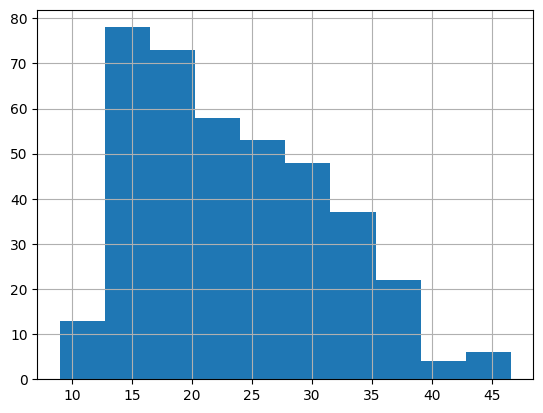

In [187]:
#Plotting in the histogram for analyzing the mpg column 
df2['mpg'].hist()

In [188]:

#Creating a new copy of the dataframe for futher manipulation 
df7 = df2.copy(deep = True)
df7['mpg'].describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

In [189]:
#Assiging the High Medium Low values to the new Class_mpg column formed based on the mpg 
#Values for their corresponding column and the frequency of the cars in each category
df7['Class_mpg'] = pd.NA
for i in range(0,len(df7)):
    if df7['mpg'].iloc[i] < 19 :
        df7['Class_mpg'].iloc[i] = 'Low'
    elif df7['mpg'].iloc[i]<27 and  df7['mpg'].iloc[i]>=19:
        df7['Class_mpg'].iloc[i] = 'Medium'
    elif df7['mpg'].iloc[i]>= 27 and  df7['mpg'].iloc[i]<= 46.6:
        df7['Class_mpg'].iloc[i]  = 'High'

C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2232719696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['Class_mpg'].iloc[i] = 'Low'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2232719696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['Class_mpg'].iloc[i] = 'Medium'
C:\Users\Puru\AppData\Local\Temp\ipykernel_2604\2232719696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['Class_mpg'].iloc[i]  = 'High'


In [190]:
#verifying the frequency of cars in the new column formed 
df7['Class_mpg'].value_counts()

Low       131
High      131
Medium    130
Name: Class_mpg, dtype: int64

In [191]:
#Forming a new dataframe and dropping the columns not required for PCA Analysis
df8 = df7.copy(deep = True)
df8 = df8.drop(['cylinders' , 'model_year' , 'car_name' ,  'year_class' , 'Brand' , 'origin' , 'Class_mpg'], axis = 1)
df8

,mpg,displacement,horsepower,weight,acceleration
0,18.0,307.0,130.0,3504.0,12.0
1,15.0,350.0,165.0,3693.0,11.5
2,18.0,318.0,150.0,3436.0,11.0
3,16.0,304.0,150.0,3433.0,12.0
4,17.0,302.0,140.0,3449.0,10.5
...,...,...,...,...,...
395,27.0,140.0,86.0,2790.0,15.6
396,44.0,97.0,52.0,2130.0,21.9
397,32.0,135.0,84.0,2295.0,11.6
398,28.0,120.0,79.0,2625.0,18.6


In [192]:
#Scaling the dataset for the PCA operation to be performed 
sc6 = StandardScaler()
df8_scaled = sc6.fit_transform(df8)

In [193]:
df8_scaled.shape

(392, 5)

In [194]:
#performing the PCA on the dataset by passing in the number of components that should be returned by the PCA 
from sklearn.decomposition import PCA 
pca_1 = PCA(n_components = 3 )
pca_final = pca_1.fit_transform(df8_scaled)

In [195]:

pca_final.shape

(392, 3)

In [196]:
#Converting the PCA back from the Array to dataframe format  
pca_df1 = pd.DataFrame(
    data=pca_final, 
    columns=['PC1', 'PC2' ,'PC3'])


In [197]:
pca_df1  

,PC1,PC2,PC3
0,1.902268,-0.678270,-0.042722
1,2.895515,-0.709214,-0.005084
2,2.301772,-1.082227,0.006659
3,2.223623,-0.693157,-0.206381
4,2.224482,-1.188635,-0.225629
...,...,...,...
387,-0.802754,-0.197225,0.033354
388,-3.569745,0.989743,1.632088
389,-0.908436,-1.895059,0.136309
390,-1.511811,0.680077,0.134096


In [198]:
#Assigning the Class_mpg class values to the PCA Dataframe 
target_names = df7['Class_mpg']
pca_df1['target'] = target_names

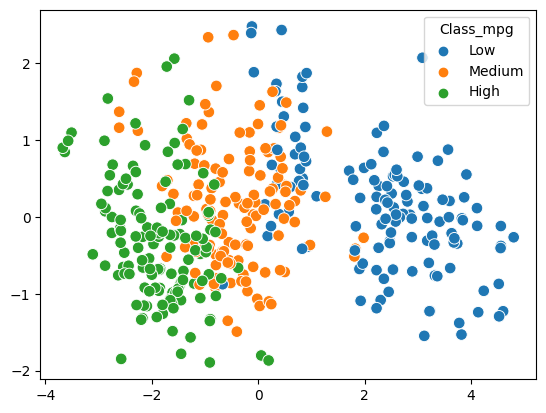

In [200]:
#Finally scatter plotting in the mpg by keeping the first two PCA's as the scale 
sea.scatterplot(x = np.array(pca_df1.iloc[:,0]) , y = np.array(pca_df1.iloc[:,1]) , s= 70 , hue=df7['Class_mpg'] )
plt.show()